In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python import debug as tf_debug
from datetime import datetime 
%load_ext autotime
%matplotlib inline 

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 15.7 s


In [18]:
tf.reset_default_graph()

time: 228 ms


In [19]:
def softmax_pooling(x):
    coefs = tf.nn.softmax(x, dim = -1)
    softmax_pool = tf.reduce_sum(tf.multiply(coefs, x), axis = -1)
    return softmax_pool

time: 379 ms


In [20]:
class PhysicalNet: 
    
    def __init__(self, layer_sizes, input_size, output_size, keep_prob = 0.9, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.output_size = output_size
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        
        self.init_weights()
        self.init_biases()
        
    def init_weights(self):
        with tf.variable_scope("phys_variable") as scope:
            for i in range(self.nb_layers):
                if i == 0:
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev), name = "weight_" + str(i))
                    W = tf.get_variable("weight_" + str(i), shape=[self.layer_sizes[i], self.input_size],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                elif i != (self.nb_layers - 1):
                    W = tf.get_variable("weight_" + str(i), shape=[self.layer_sizes[(i+1)], self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]], stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                else:
                    W = tf.get_variable("weight_" + str(i), shape=[self.output_size, self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]], stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        with tf.variable_scope("phys_variable") as scope:
            for i in range(self.nb_layers):
                #B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1], stddev = self.stddev), name = "bias_" + str(i))
                B = tf.get_variable("bias_" + str(i), shape=[self.layer_sizes[i], 1],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                tf.summary.histogram('phys_net_bias_'+ str(i), B)
                self.Biases.append(B)
            
            
    def compute_output(self, x): ## ADD THE DROPOUTS ## ADD THE SOFTMAX AT THE END ?
            for i in range(self.nb_layers):
                W = self.Weights[i]
                b = self.Biases[i]
                if i != (self.nb_layers - 1):
                    x = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
                else:
                    x = tf.nn.elu(tf.matmul(W, x) + b)
            
            return x

time: 968 ms


In [21]:
class CommunicationNet: ## ADD THE MEMORY !! 
    
    def __init__(self, layer_sizes, input_size, keep_prob = 0.9, memory_size = 32,
                 stddev_epsilon = 0.35, output_size = 256, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.layer_sizes[(self.nb_layers-1)], self.memory_size]
                                                            ,stddev = self.stddev))
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        with tf.variable_scope("com_variable") as scope:
            for i in range(self.nb_layers):
                if i == 0:
                    W = tf.get_variable("com_net_weight_" + str(i), shape=[self.layer_sizes[i], self.input_size],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                elif i != (self.nb_layers - 1):
                    W = tf.get_variable("com_net_weight_" + str(i), shape=[self.layer_sizes[(i+1)], self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                else:
                    W = tf.get_variable("com_net_weight_" + str(i), shape=[self.output_size, self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('com_net_weight_'+ str(i), W)

                self.Weights.append(W)
       
    
    def init_biases(self):
        with tf.variable_scope("com_variable") as scope:
            for i in range(self.nb_layers):
                #B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1],stddev = self.stddev), name = "bias_" + str(i))
                B = tf.Variable(tf.zeros([self.layer_sizes[i], 1]), name = "com_net_bias_" + str(i))
                tf.summary.histogram('com_net_bias_'+ str(i), B)
                self.Biases.append(B)
       
    
    def def_delta_mem(self):
        #self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev), name = "weight_mem_com")
        self.W_mem = tf.get_variable("weight_mem_com" , shape=[self.memory_size,self.output_size],
                            initializer=tf.contrib.layers.xavier_initializer(False))
        self.b_mem = tf.Variable(tf.zeros(shape = [self.memory_size, 1]), name = "bias_mem_com")

        
    def compute_output(self, x, memory):## ADD THE DROPOUTS AND SOFTMAX ?
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (self.nb_layers - 1):
                x = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                x = tf.nn.elu(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
                
            
        delta_mem = tf.add(tf.matmul(self.W_mem, x),self.b_mem)
        return x, delta_mem

time: 842 ms


In [22]:
class LastNet: ## ADD THE MEMORY !! The memory initialization is random ==> set it 0
    
    def __init__(self, layer_sizes, input_size, keep_prob = 0.9, memory_size = 32, 
                 stddev_epsilon = 0.35, output_size = 24, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.output_size, self.memory_size],stddev = self.stddev))
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(self.nb_layers):
                if i == 0:
                    W = tf.get_variable("lastnet_weight_" + str(i), shape=[self.layer_sizes[i], self.input_size],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                elif i != (self.nb_layers - 1):
                    W = tf.get_variable("last_net_weight_" + str(i), shape=[self.layer_sizes[(i+1)], self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                else:
                    W = tf.get_variable("last_net_weight_" + str(i), shape=[self.output_size, self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('last_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(self.nb_layers):
                if i != (self.nb_layers - 1):
                    #B = tf.Variable(tf.random_normal([self.layer_sizes[i+1], 1],stddev = self.stddev), name = "bias_" + str(i))
                    B = tf.Variable(tf.zeros([self.layer_sizes[i], 1]), name = "last_net_bias_" + str(i))
                    tf.summary.histogram('last_net_bias_'+ str(i), B)
                else:
                    #B = tf.Variable(tf.random_normal([self.output_size, 1], stddev = self.stddev), name = "bias_" + str(i))
                    B = tf.Variable(tf.zeros([self.output_size, 1]), name = "last_net_bias_" + str(i))
                    tf.summary.histogram('last_net_bias_'+ str(i), B)

                self.Biases.append(B)

        
    def def_delta_mem(self):
        #self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev),
        #                        name = "weight_mem_last")
        self.W_mem = tf.get_variable("weight_mem_last", shape=[self.memory_size,self.output_size],
                                initializer=tf.contrib.layers.xavier_initializer(False))
        self.b_mem = tf.Variable(tf.zeros(shape = [self.memory_size, 1]),
                                name = "bias_mem_last")
        
    def compute_output(self, x, memory):## ADD THE DROPOUTS !!! REMOVE THE SOFTMAX OF THE LAST LAYER !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (self.nb_layers - 1):
                x = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                x = tf.nn.elu(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
               
        delta_mem = tf.add(tf.matmul(self.W_mem, x),self.b_mem)
        return x, delta_mem

time: 581 ms


In [23]:
class Policy_Phys:
    
    def __init__(self, nb_agent, nb_landmark, hidden_layer_size = 256, env_dim = 2, 
                 batch_size = 1024, stddev_phys_output = 0.0001):
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.env_dim = env_dim
        self.nb_agent = nb_agent
        self.nb_landmark = nb_landmark
        self.hidden_layer_size = hidden_layer_size
        
        self.init_all()
        
    def init_phys_module(self):
        self.network_phys = PhysicalNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                              self.env_dim, self.hidden_layer_size)


    def compute_output(self, x_agent):
        output = []
        for x in x_agent:
            output.append(tf.reshape(self.network_phys.compute_output(x), [256, -1, 1]))
            
        all_phys_output = tf.concat(output, axis = 2)
        self.PhiX = softmax_pooling(all_phys_output)
        return self.PhiX

    def init_all(self):
        self.init_phys_module()

time: 301 ms


In [24]:
class Policy_Utterance:
    
    def __init__(self, nb_agent, goal_size, vocabulary_size = 20, 
                 hidden_layer_size = 256, memory_size = 32, temperature = 1, batch_size = 1024,
                 stddev_phys_output = 0.0001):
        self.size_goal = goal_size
        self.nb_agent = nb_agent
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.temperature = temperature
        self.memory_size = memory_size
        self.vocabulary_size = vocabulary_size
        self.hidden_layer_size = hidden_layer_size
        self.goal = tf.placeholder(tf.float32, [self.size_goal, None])
        
        self.init_all()
        

    def init_com_module(self):## Les poids seront les mêmes pour tous les agents
        self.network_com = CommunicationNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                             self.vocabulary_size)


    def init_all(self):
        self.init_com_module()

    def compute_output(self, c_agent, mem_agent):
        output = []
        delta_mem = []
        for c, mem in zip(c_agent, mem_agent):
            o, m = self.network_com.compute_output(c, mem)
            output.append(tf.reshape(o, [256, -1, 1]))
            delta_mem.append(m)

        all_comm_output = tf.concat(output, axis = 2)
        PhiC = softmax_pooling(all_comm_output)
        
        return PhiC, delta_mem

time: 321 ms


In [25]:
class Policy_Last:
    
    def __init__(self, hidden_layer_size = 256, size_goal = 8, memory_size = 32, batch_size = 1024, 
                 stddev_phys_output = 0.0001, vocabulary_size = 20, env_dim = 2, temperature = 1):
        self.temperature = temperature
        self.stddev_phys_output = stddev_phys_output
        self.env_dim = env_dim
        self.vocabulary_size = vocabulary_size 
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.hidden_layer_size = hidden_layer_size
        self.size_goal = size_goal
        self.init_all()

    def init_last_module(self):
        inp_size = (2*self.hidden_layer_size + self.size_goal)
        out_size = self.vocabulary_size + 2*self.env_dim
        self.last_net = LastNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                inp_size, output_size = out_size)

    def init_all(self):
        self.init_last_module()

    def sample_utterance(self, output):## Vérifier qu'on prend un bon slice sur l'output
        u = -tf.log(-tf.log(tf.random_uniform(shape = [self.vocabulary_size, self.batch_size],dtype=tf.float32)))
        utterance_output = tf.slice(output, [2*self.env_dim, 0], [self.vocabulary_size, self.batch_size])
        gumbel = tf.exp((utterance_output + u)/self.temperature)
        denoms = tf.reduce_sum(gumbel, axis = 0)
        utterance = gumbel/denoms
        return utterance
        
    def sample_phys(self, output):
        u = tf.random_normal(shape = [2*self.env_dim, self.batch_size],dtype=tf.float32, stddev = self.stddev_phys_output)
        o = tf.add(tf.slice(output, [0, 0], [2*self.env_dim, self.batch_size]), u)
        sample_move = tf.slice(o, [0, 0], [self.env_dim, self.batch_size])
        sample_gaze  = tf.slice(o, [self.env_dim, 0], [self.env_dim, self.batch_size])
        return sample_move, sample_gaze
            
    def compute_output(self, PhiX, PhiC, last_mem, goal):
        Phi = tf.concat([PhiX, goal, PhiC], axis = 0)
        output, memory = self.last_net.compute_output(Phi, last_mem)
        utterance = self.sample_utterance(output)
        move, gaze = self.sample_phys(output)
        return move, gaze, utterance, memory

time: 275 ms


In [26]:
class Policy:# Two memories per Agent: one for the communication module, the other one for the last module. Is it correct ?

    def __init__(self,nb_agent, nb_landmark, goal_size, vocabulary_size = 20, hidden_layer_size = 256,
                 memory_size = 32, temperature = 1, batch_size = 1024, stddev_phys_output = 0.0001, env_dim = 2,
                 goal_type_size = 3, time_delta = 0.1, damping_coeff = 0.5):
        self.nb_agent = nb_agent
        self.goal_size = goal_size
        self.nb_landmark = nb_landmark
        self.env_dim = env_dim
        self.goal_type_size = goal_type_size
        self.batch_size = batch_size
        self.vocabulary_size = vocabulary_size
        self.memory_size = memory_size
        self.time_delta = time_delta
        self.damping_coeff = damping_coeff
        
        self.phys_module = Policy_Phys(self.nb_agent, self.nb_landmark)
        self.utterance_module = Policy_Utterance(self.nb_agent, self.goal_size)
        self.last_module = Policy_Last()
        
        self.list_PhiX = []
        self.list_PhiC = []
        
        self.init_placeholders()
         
    #h_pos, h_utter, h_velocity, h_gaze, h_goal_location, h_goal_type, h_col, h_mem, h_last_mem 
    def init_placeholders(self):
        self.h_pos = [tf.placeholder(tf.float32, shape = [self.env_dim, self.batch_size]) for i in range(self.nb_agent)]
        self.h_utterance = [tf.placeholder(tf.float32, shape = [self.vocabulary_size, self.batch_size]) for i in range(self.nb_agent)]
        self.h_velocity = [tf.placeholder(tf.float32, shape = [self.env_dim, self.batch_size]) for i in range(self.nb_agent)]
        self.h_gaze = [tf.placeholder(tf.float32, shape = [self.env_dim, self.batch_size]) for i in range(self.nb_agent)]
        self.h_goal_location = [tf.placeholder(tf.float32, shape = [self.env_dim, self.batch_size]) for i in range(self.nb_agent)]
        self.h_goal_type = [tf.placeholder(tf.float32, shape = [self.goal_type_size, self.batch_size]) for i in range(self.nb_agent)]
        self.h_col = [tf.placeholder(tf.float32, shape = [3, 1]) for i in range(self.nb_agent)]
        self.h_mem = [tf.placeholder(tf.float32, shape = [self.memory_size, self.batch_size]) for i in range(self.nb_agent)]
        self.h_mem_last = [tf.placeholder(tf.float32, shape = [self.memory_size, self.batch_size]) for i in range(self.nb_agent)]
        self.h_name_targets = [tf.placeholder(tf.int32, shape = [1, self.batch_size]) for i in range(self.nb_agent)]
        
        
    def get_placeholders(self):
        return [self.h_pos, self.h_utterance, self.h_velocity, self.h_gaze, self.h_goal_location, self.h_goal_type,
        self.h_col, self.h_mem, self.h_mem_last, self.h_name_targets]
    
    def get_list_goals(self, list_name_targets):
        list_goals = []
        for i in range(self.nb_agent):
            list_goals.append(self.init_goal_agent(i))
            
        return list_goals

    def init_goal_agent(self, agent_number):
        other_agents = tf.gather(self.h_col, self.h_name_targets[agent_number])
        colors = tf.reshape(tf.concat(other_agents, axis = 1), [3, self.batch_size])
        return tf.concat([self.h_goal_type[agent_number], self.h_goal_location[agent_number], colors], axis = 0)
        
    def compute_output(self, list_pos, list_utterances, list_goals, list_mem, list_last_mem):
        list_moves = []
        list_gazes = []
        list_new_utterances = []
        list_last_delta_mem = []
        PhiX = self.phys_module.compute_output(list_pos)
        PhiC, list_delta_mem = self.utterance_module.compute_output(list_utterances, list_mem)
        self.list_PhiX.append(PhiX)
        self.list_PhiC.append(PhiC)
        for last_mem, goal in zip(list_last_mem, list_goals):
            m, g, u, ldm = self.last_module.compute_output(PhiX, PhiC, last_mem, goal)
            list_moves.append(m)
            list_gazes.append(g)
            list_new_utterances.append(u)
            list_last_delta_mem.append(ldm)
            
        return list_moves, list_gazes, list_new_utterances, list_delta_mem, list_last_delta_mem
    
    def compute_reward_agents(self, new_pos, new_gaze, list_move, new_utterance, goal_locations, list_targets, goal_type): 
        ## Check the shuffle for the pos of agent and gaze is OK !!
        rewards = []
        ag_positions = []
        ag_gazes = []
        ag_goal_on_agent = []
        ag_velocities = []
        ag_utterances = []
        ag_goal_locations = []
        ag_goal_type = []
        for i in range(self.nb_agent):## Useless, take list directly
            ag_positions.append(new_pos[i])
            ag_gazes.append(new_gaze[i])
            ag_velocities.append(list_move[i])
            ag_utterances.append(new_utterance[i])
            ag_goal_locations.append(goal_locations[i])
            ag_goal_type.append(goal_type[i])
            
        agent_positions = tf.stack(ag_positions, axis = 2)
        agent_gazes = tf.stack(ag_gazes, axis = 2)
        agent_velocities = tf.stack(ag_velocities, axis = 2)
        agent_utterances = tf.stack(ag_utterances, axis = 2)
        agent_goal_locations = tf.stack(ag_goal_locations, axis = 2)
        agent_goal_type = tf.stack(ag_goal_type, axis = 2)
        
        for i in range(self.nb_agent):
            name_target = tf.reshape(tf.gather_nd(list_targets[i], [[0,k] for k in range(self.batch_size)]), [self.batch_size, 1])
            l1 = tf.concat([tf.constant([[0] for i in range(self.batch_size)]), tf.constant([[i] for i in range(self.batch_size)]),
                           name_target], axis = 1) 
            l2 = tf.concat([tf.constant([[1] for i in range(self.batch_size)]), tf.constant([[i] for i in range(self.batch_size)]),
                           name_target], axis = 1)            
            l3 = [l1, l2]

            position_target = tf.gather_nd(agent_positions, l3)
            gaze_target = tf.gather_nd(agent_gazes, l3)
            
            own_velocity = tf.reshape(tf.slice(agent_velocities, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])  
            
            own_gaze = tf.reshape(tf.slice(agent_gazes, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])
            
            own_goal_location = tf.reshape(tf.slice(agent_goal_locations, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                          [self.env_dim, self.batch_size])
            
            own_utterance = tf.reshape(tf.slice(agent_utterances, [0, 0, i], [self.vocabulary_size, self.batch_size, 1]), 
                                         [self.vocabulary_size, self.batch_size])
            
            own_goal_type = tf.reshape(tf.slice(agent_goal_type, [0, 0, i], [3, self.batch_size, 1]), 
                                          [3, self.batch_size])
            
            reward_agent = self.compute_reward_agent(position_target, gaze_target, own_velocity, own_gaze,
                                                      own_utterance, own_goal_location, own_goal_type)
            rewards.append(reward_agent)
          
        #Concat on another axis
        rewards_batch = tf.reduce_mean(tf.concat(rewards, axis = 0), axis = 0)
        return rewards_batch
    
    
    def compute_reward_agent(self,goal_agent_pos, goal_agent_gaze, output_velocity, output_gaze, new_utterance, 
                             goal_location, goal_type): 
        ## Modifier la norme u, il s'agit de l'output
        #du réseau, non pas de la position !
        with tf.name_scope("reward_computation"):
            r1 = tf.reshape(tf.square(tf.norm(goal_agent_pos - goal_location, axis = 0)), [1, self.batch_size])
            r2 = tf.reshape(tf.square(tf.norm(goal_agent_gaze - goal_location, axis = 0)), [1, self.batch_size])
            utt_norm = tf.square(tf.norm(new_utterance, axis = 0))
            u_norm = tf.square(tf.norm(tf.concat([output_velocity, output_gaze], axis = 0), axis = 0))
            vec = tf.concat([r1, r2, tf.zeros([1,self.batch_size], tf.float32)], axis = 0)
            v1 = tf.reduce_sum(tf.multiply(vec, goal_type), axis = 0)
            r = -(v1 + utt_norm + u_norm)
        return r
    
    def compute_new_state(self, tensor_new_utterance, tensor_new_velocity, tensor_new_gaze, tensor_memory_delta, 
                          tensor_memory_delta_last, tensor_pos, tensor_velocity, tensor_memory, tensor_memory_last):
        ## ADD THE FORCES TO THE NEW VELOCITY !!
        ## ADD GAUSSIAN NOISE TO THE MEMORY UPDATE !
        new_pos = tensor_pos + tf.multiply(tensor_velocity,self.time_delta)
        new_velocity = (tf.multiply(tensor_velocity, self.damping_coeff) + 
                                                  tf.multiply(tensor_new_velocity, self.time_delta))
        new_gaze = tensor_new_gaze
        new_memory = tensor_memory + tensor_memory_delta
        new_memory_last = tensor_memory_last + tensor_memory_delta_last
        new_utterance = tensor_new_utterance
        
        return new_pos, new_velocity, new_gaze, new_utterance, new_memory, new_memory_last

time: 1.94 s


In [37]:
class Agent:
    
    def __init__(self, name, name_target, vocabulary_size = 20, batch_size = 1024, env_dim = 2, goal_size = 8, 
                 memory_size = 32, time_delta = 0.1, nb_actions = 3, damping_coeff = 0.5):
        self.nb_actions = nb_actions
        self.name_target = name_target
        self.env_dim = env_dim
        self.memory_size = memory_size
        self.name = name
        self.goal_size = goal_size
        self.batch_size = batch_size
        self.vocabulary_size = vocabulary_size
        
        #with tf.variable_scope("agent" + str(self.name)):
        #    self.pos = tf.placeholder(tf.float32, [self.env_dim, self.batch_size]) 
        #    self.velocity = tf.placeholder(tf.float32, [self.env_dim, self.batch_size])
        #    self.gaze = tf.placeholder(tf.float32, [self.env_dim, self.batch_size])
        #    self.utterance = tf.placeholder(tf.float32, [self.vocabulary_size, self.batch_size])

        #   self.memory = tf.placeholder(tf.float32, [self.memory_size,self.batch_size])

        #   self.memory_last = tf.placeholder(tf.float32, [self.memory_size, self.batch_size])
    
        #    self.tensor_goal_location = tf.placeholder(tf.float32, [self.env_dim, self.batch_size])
        #    self.tensor_goal_type = tf.placeholder(tf.float32, [self.nb_actions, self.batch_size])
        #    self.col = tf.placeholder(tf.float32, [3, 1])
                                            
    def get_position(self):
        return self.pos
    
    def get_velocity(self):
        return self.velocity
    
    def get_gaze(self):
        return self.gaze

    def get_utterance(self):
        return self.utterance
                                        
    def get_memory(self):
        return self.memory
    
    def get_memory_last(self):
        return self.memory_last
    
    def get_phys_state(self):
        return (self.get_position(), self.get_velocity(), self.get_gaze(), self.get_col)
    
    def get_name_target(self):
        return self.name_target
    
    def get_goal(self, other_ags):
        other_agents = [other_ags[i].get_color() for i in self.name_target[0, :]]
        colors = tf.concat(other_agents, axis = 1)
        return tf.concat([self.tensor_goal_type, self.tensor_goal_location, colors], axis = 0)
          
    def get_all_iterations_variables(self):
        return self.pos, self.velocity, self.gaze, self.utterance, self.memory, self.memory_last
    
    def get_color(self):
        return self.col


time: 238 ms


In [55]:
class Environment:
    # Use this class to instantiate an environment on N batches. All batches share the same structure, but not not the
    # same goals.
    def __init__(self, nb_agents = 3, nb_landmarks = 0, time_delta = 0.1, env_dim = 2, batch_size = 1024,
                 goal_type_size = 3, damping_coef = 0.5, vocabulary_size = 20):
        self.env_dim = env_dim
        self.vocabulary_size = vocabulary_size
        self.batch_size = batch_size
        self.goal_type_size = goal_type_size
        self.goal_size = self.goal_type_size + 3 + self.env_dim
        self.nb_agents = nb_agents
        self.nb_landmarks = nb_landmarks
        self.time_delta = tf.constant([time_delta])
        self.list_agents = []
        self.list_phys_tensors = []
        self.list_utter_tensors = []
        self.list_mem_tensors = []
        self.list_mem_last_tensors = []
        self.list_goals_tensors = []
        self.list_velocity_tensors = []
        self.list_gaze_tensors = []
        self.goal_type_tensors = []
        self.col_tensors = []
        self.goal_location_tensors = []
        self.damping_coeff = damping_coef
        self.enc = OneHotEncoder(n_values=self.goal_type_size, sparse=False)
    
        
    def init_agents(self):
        for i in range(self.nb_agents):
            ag = Agent(name = i, name_target = self.name_of_targets[i])
            self.list_agents.append(ag)
            self.list_phys_tensors.append(ag.get_position())
            self.list_utter_tensors.append(ag.get_utterance())
            self.list_velocity_tensors.append(ag.velocity)
            self.list_gaze_tensors.append(ag.velocity)
            self.goal_location_tensors.append(ag.tensor_goal_location)
            self.goal_type_tensors.append(ag.tensor_goal_type)
            self.col_tensors.append(ag.col)
            self.list_mem_tensors.append(ag.get_memory())
            self.list_mem_last_tensors.append(ag.get_memory_last())
            
    def init_goals_tensors(self):
        for ag in self.list_agents: 
            self.list_goals_tensors.append(ag.get_goal(self.list_agents))

    def random_env_init(self):
        self.name_of_targets = []
        self.p = []
        self.v = []
        self.g = []
        self.go = []
        self.co = []
        self.gl = []
        self.utter = []
        self.memory = []
        self.memory_last = []
        for i in range(self.nb_agents):
            #self.name_of_targets.append(np.random.randint(0, self.nb_agents, (1, self.batch_size)))
            self.name_of_targets.append((np.ones((1, self.batch_size))*i))
            bound = 5
            self.p.append(np.round(np.random.uniform(-bound, bound, [2, self.batch_size]), 2))
            self.gl.append(np.round(np.random.uniform(-bound, bound, [2, self.batch_size]), 2))
            self.v.append(np.zeros([self.env_dim, self.batch_size]))
            self.g.append(np.zeros([self.env_dim, self.batch_size]))
            J = np.random.choice(self.goal_type_size, self.batch_size)
            self.go.append(np.transpose(self.enc.fit_transform(J.reshape(-1,1))))
            #self.go.append(np.transpose(np.array([[1,0, 0] for i in range(self.batch_size)])))
            self.co.append(np.random.uniform(0, 255, [3, 1]))
            
            self.utter.append(np.zeros([20, self.batch_size]))
            self.memory.append(np.zeros([32, self.batch_size]))
            self.memory_last.append(np.zeros([32, self.batch_size]))
            
            
        
        #self.init_agents()
        #self.init_goals_tensors()   
        return self.p, self.gl, self.v, self.g, self.go, self.utter, self.co, self.memory, self.memory_last, self.name_of_targets
    
    def get_placeholders(self):
        return [self.list_agents, self.list_phys_tensors, self.list_utter_tensors,self.list_velocity_tensors, 
        self.list_gaze_tensors, self.goal_location_tensors, self.goal_type_tensors, self.col_tensors, 
        self.list_mem_tensors, self.list_mem_last_tensors]

time: 108 ms


In [65]:
class Experiment:
    
    def __init__(self, nb_agents, nb_landmarks, time_horizon, batch_size = 1024, time_delta = 0.1):
        #tf.reset_default_graph()
        self.time_horizon = time_horizon
        self.batch_size = batch_size
        self.nb_agents = nb_agents
        self.nb_landmarks = nb_landmarks
        self.time_delta = time_delta
        
        self.instantiate_environment()
        self.define_placeholders()
        
    def instantiate_environment(self):## ADD THE AUXILIARY REWARDS !!!!!
        self.env = Environment(nb_agents = self.nb_agents)
        self.policy = Policy(self.nb_agents, self.nb_landmarks, self.env.goal_size)
     
    def define_placeholders(self):
        (self.h_pos, self.h_utter, self.h_velocity, self.h_gaze, self.h_goal_location, self.h_goal_type, 
         self.h_col, self.h_mem, self.h_last_mem, self.h_name_targets) = self.policy.get_placeholders()
        self.list_goals = self.policy.get_list_goals(self.h_name_targets)
        
    def create_feed_dict(self, p, gl, v, g, go, utter, co, memory, memory_last, name_targets):
        init_values = p + gl + v + g + go + utter + co + memory + memory_last + name_targets
        placeholders_list = (self.h_pos + self.h_goal_location + self.h_velocity + self.h_gaze + self.h_goal_type + 
                             self.h_utter + self.h_col + self.h_mem + self.h_last_mem + self.h_name_targets)
        feed_dict = {a:b for a,b in zip(placeholders_list, init_values)}
        return feed_dict
        
    def train_batch(self, step_number, sess):
        self.overall_res = []
        self.all_env = []
        t = tf.constant(1)
        return_sofar = tf.constant(0.0)
        self.suite_pos = []
        arguments = [self.h_pos, self.h_gaze, self.h_utter, self.h_velocity, self.list_goals, self.h_mem, self.h_last_mem, 
                     self.h_goal_location, self.h_name_targets, self.h_goal_type, return_sofar, t]
        result = tf.while_loop(self.condition, self.body, loop_vars = arguments)
        #step = optimizer.minimize(-result[-2])
        global_step = tf.Variable(0, trainable=False)
        #starter_learning_rate = 0.00001 #0.97
        learning_rate = 0.00001
        #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
        #                                   1, 0.8, staircase=True)
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        tf.summary.scalar('accuracy', result[-2])
        tf.summary.scalar('learning rate', learning_rate)
        grads = optimizer.compute_gradients(-result[-2])
        step = optimizer.apply_gradients(grads, global_step=global_step)
        for index, grad in enumerate(grads):
            tf.summary.histogram("{}-grad".format(grads[index][1].name), grads[index])
        
        print("Initializing variables")
        init_op = tf.global_variables_initializer()
        merged = tf.summary.merge_all()
        file_writer = tf.summary.FileWriter('Summary/train',sess.graph)
        sess.run(init_op)
        sess.graph.finalize()
        print("Start running")
        start = datetime.now()
        for j in range(step_number):
            p, gl, v, g, go, utter, co,  memory, memory_last, name_targets = self.env.random_env_init()
            self.all_env.append([p,gl,v,g,go,utter,co,memory,memory_last,name_targets])
            self.feed_dict = self.create_feed_dict(p, gl, v, g, go, utter, co, memory, memory_last, name_targets)
            list_output = sess.run([step] + result, self.feed_dict)
            #file_writer.add_summary(list_output[1], j)
            self.overall_res.append(list_output)
            if j%10 == 0:
                final_pos = list_output[1]
                final_gaze = list_output[2]
                final_dist = [np.sqrt(np.sum((pos - gl[k])**2, axis = 0)) for k,pos in enumerate(final_pos)]
                final_gaze = [np.sqrt(np.sum((gaze - gl[k])**2, axis = 0)) for k,gaze in enumerate(final_gaze)]
                zeros = np.zeros(self.batch_size)
                self.overall_res.append(list_output)
                print("iteration " + str(j))
                print(list_output[-2])
                for l in range(self.nb_agents):
                    r = np.stack([final_dist[l], final_gaze[l], zeros], axis = 0)
                    dist_obj = np.sum(np.multiply(r, go[l]), axis = 0)
                    final_dist_mean = np.mean(dist_obj)
                    final_dist_median = np.median(dist_obj)
                    print("-- Agent" + str(l))
                    print("---final distance mean: " + str(final_dist_mean))
                    print("---final distance median:" + str(final_dist_mean))
                    
                print("computing time")
                print(datetime.now() - start)
                start = datetime.now()
                print("\n")
        
        return self.overall_res
    
    # Structure of args [h_pos, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, return_sofar, t]
    def body(self, h_pos, h_gaze, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, h_goal_locations, h_name_targets, 
             h_goal_type, return_sofar, t):
        list_moves, list_gazes, list_utterances, list_delta_mem, list_last_delta_mem =self.policy.compute_output(
                h_pos, h_utterance, list_goals, h_mem, h_mem_last)
        new_pos_agents = []
        new_utterance_agents = []
        new_velocity_agents = []
        new_gaze_agents = []
        new_h_mem_agents = []
        new_h_mem_last_agents = []
        for i in range(self.env.nb_agents):
            output_utterance = list_utterances[i]
            output_velocity = list_moves[i]
            output_gaze = list_gazes[i]
            memory_delta = list_delta_mem[i]
            memory_delta_last = list_last_delta_mem[i]
            
            new_pos, new_velocity, new_gaze, new_utterance, new_memory, new_memory_last = self.policy.compute_new_state(
                output_utterance, output_velocity, output_gaze, memory_delta, memory_delta_last, h_pos[i], 
                h_velocity[i], h_mem[i], h_mem_last[i])
            
            new_pos_agents.append(new_pos)
            new_velocity_agents.append(new_velocity)
            new_utterance_agents.append(new_utterance)
            new_gaze_agents.append(new_gaze)
            new_h_mem_agents.append(new_memory)
            new_h_mem_last_agents.append(new_memory_last)

        new_reward_batch = self.policy.compute_reward_agents(new_pos_agents, new_gaze_agents, new_velocity_agents,
                                              new_utterance_agents, h_goal_locations, h_name_targets, h_goal_type)
        

        return_sofar += new_reward_batch
        t += 1
        
        return [new_pos_agents, new_gaze_agents, new_utterance_agents, new_velocity_agents, list_goals, new_h_mem_agents, new_h_mem_last_agents, 
        h_goal_locations, h_name_targets, h_goal_type, return_sofar, t]
        
    # Structure of args [h_pos, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, return_sofar, t]
    def condition(self, h_pos, h_gaze, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, h_goal_locations, 
                  h_name_targets, h_goal_type, return_sofar, t):
        return tf.less(t, self.time_horizon)
    

time: 397 ms


In [66]:
tf.reset_default_graph()
exp = Experiment(2, 0, 50)
with tf.Session() as sess:
    l = exp.train_batch(5000, sess)

Tensor("while/Reshape_8:0", shape=(1024, 1), dtype=int32)
Tensor("while/Reshape_14:0", shape=(1024, 1), dtype=int32)
INFO:tensorflow:Summary name learning rate is illegal; using learning_rate instead.


INFO:tensorflow:Summary name learning rate is illegal; using learning_rate instead.


INFO:tensorflow:Summary name phys_variable/weight_0:0-grad is illegal; using phys_variable/weight_0_0-grad instead.


INFO:tensorflow:Summary name phys_variable/weight_0:0-grad is illegal; using phys_variable/weight_0_0-grad instead.


INFO:tensorflow:Summary name phys_variable/weight_1:0-grad is illegal; using phys_variable/weight_1_0-grad instead.


INFO:tensorflow:Summary name phys_variable/weight_1:0-grad is illegal; using phys_variable/weight_1_0-grad instead.


INFO:tensorflow:Summary name phys_variable/weight_2:0-grad is illegal; using phys_variable/weight_2_0-grad instead.


INFO:tensorflow:Summary name phys_variable/weight_2:0-grad is illegal; using phys_variable/weight_2_0-grad instead.


INFO:tensorflow:Summary name phys_variable/bias_0:0-grad is illegal; using phys_variable/bias_0_0-grad instead.


INFO:tensorflow:Summary name phys_variable/bias_0:0-grad is illegal; using phys_variable/bias_0_0-grad instead.


INFO:tensorflow:Summary name phys_variable/bias_1:0-grad is illegal; using phys_variable/bias_1_0-grad instead.


INFO:tensorflow:Summary name phys_variable/bias_1:0-grad is illegal; using phys_variable/bias_1_0-grad instead.


INFO:tensorflow:Summary name phys_variable/bias_2:0-grad is illegal; using phys_variable/bias_2_0-grad instead.


INFO:tensorflow:Summary name phys_variable/bias_2:0-grad is illegal; using phys_variable/bias_2_0-grad instead.


INFO:tensorflow:Summary name Variable:0-grad is illegal; using Variable_0-grad instead.


INFO:tensorflow:Summary name Variable:0-grad is illegal; using Variable_0-grad instead.


INFO:tensorflow:Summary name com_variable/com_net_weight_0:0-grad is illegal; using com_variable/com_net_weight_0_0-grad instead.


INFO:tensorflow:Summary name com_variable/com_net_weight_0:0-grad is illegal; using com_variable/com_net_weight_0_0-grad instead.


INFO:tensorflow:Summary name com_variable/com_net_weight_1:0-grad is illegal; using com_variable/com_net_weight_1_0-grad instead.


INFO:tensorflow:Summary name com_variable/com_net_weight_1:0-grad is illegal; using com_variable/com_net_weight_1_0-grad instead.


INFO:tensorflow:Summary name com_variable/com_net_weight_2:0-grad is illegal; using com_variable/com_net_weight_2_0-grad instead.


INFO:tensorflow:Summary name com_variable/com_net_weight_2:0-grad is illegal; using com_variable/com_net_weight_2_0-grad instead.


INFO:tensorflow:Summary name com_variable_1/com_net_bias_0:0-grad is illegal; using com_variable_1/com_net_bias_0_0-grad instead.


INFO:tensorflow:Summary name com_variable_1/com_net_bias_0:0-grad is illegal; using com_variable_1/com_net_bias_0_0-grad instead.


INFO:tensorflow:Summary name com_variable_1/com_net_bias_1:0-grad is illegal; using com_variable_1/com_net_bias_1_0-grad instead.


INFO:tensorflow:Summary name com_variable_1/com_net_bias_1:0-grad is illegal; using com_variable_1/com_net_bias_1_0-grad instead.


INFO:tensorflow:Summary name com_variable_1/com_net_bias_2:0-grad is illegal; using com_variable_1/com_net_bias_2_0-grad instead.


INFO:tensorflow:Summary name com_variable_1/com_net_bias_2:0-grad is illegal; using com_variable_1/com_net_bias_2_0-grad instead.


INFO:tensorflow:Summary name weight_mem_com:0-grad is illegal; using weight_mem_com_0-grad instead.


INFO:tensorflow:Summary name weight_mem_com:0-grad is illegal; using weight_mem_com_0-grad instead.


INFO:tensorflow:Summary name bias_mem_com:0-grad is illegal; using bias_mem_com_0-grad instead.


INFO:tensorflow:Summary name bias_mem_com:0-grad is illegal; using bias_mem_com_0-grad instead.


INFO:tensorflow:Summary name Variable_1:0-grad is illegal; using Variable_1_0-grad instead.


INFO:tensorflow:Summary name Variable_1:0-grad is illegal; using Variable_1_0-grad instead.


INFO:tensorflow:Summary name last_variable/lastnet_weight_0:0-grad is illegal; using last_variable/lastnet_weight_0_0-grad instead.


INFO:tensorflow:Summary name last_variable/lastnet_weight_0:0-grad is illegal; using last_variable/lastnet_weight_0_0-grad instead.


INFO:tensorflow:Summary name last_variable/last_net_weight_1:0-grad is illegal; using last_variable/last_net_weight_1_0-grad instead.


INFO:tensorflow:Summary name last_variable/last_net_weight_1:0-grad is illegal; using last_variable/last_net_weight_1_0-grad instead.


INFO:tensorflow:Summary name last_variable/last_net_weight_2:0-grad is illegal; using last_variable/last_net_weight_2_0-grad instead.


INFO:tensorflow:Summary name last_variable/last_net_weight_2:0-grad is illegal; using last_variable/last_net_weight_2_0-grad instead.


INFO:tensorflow:Summary name last_variable_1/last_net_bias_0:0-grad is illegal; using last_variable_1/last_net_bias_0_0-grad instead.


INFO:tensorflow:Summary name last_variable_1/last_net_bias_0:0-grad is illegal; using last_variable_1/last_net_bias_0_0-grad instead.


INFO:tensorflow:Summary name last_variable_1/last_net_bias_1:0-grad is illegal; using last_variable_1/last_net_bias_1_0-grad instead.


INFO:tensorflow:Summary name last_variable_1/last_net_bias_1:0-grad is illegal; using last_variable_1/last_net_bias_1_0-grad instead.


INFO:tensorflow:Summary name last_variable_1/last_net_bias_2:0-grad is illegal; using last_variable_1/last_net_bias_2_0-grad instead.


INFO:tensorflow:Summary name last_variable_1/last_net_bias_2:0-grad is illegal; using last_variable_1/last_net_bias_2_0-grad instead.


INFO:tensorflow:Summary name weight_mem_last:0-grad is illegal; using weight_mem_last_0-grad instead.


INFO:tensorflow:Summary name weight_mem_last:0-grad is illegal; using weight_mem_last_0-grad instead.


INFO:tensorflow:Summary name bias_mem_last:0-grad is illegal; using bias_mem_last_0-grad instead.


INFO:tensorflow:Summary name bias_mem_last:0-grad is illegal; using bias_mem_last_0-grad instead.


Initializing variables
Start running
iteration 0
-6768.5
-- Agent0
---final distance mean: 4.71020076454
---final distance median:4.71020076454
-- Agent1
---final distance mean: 4.40957167891
---final distance median:4.40957167891
computing time
0:00:13.879881


iteration 10
-4385.65
-- Agent0
---final distance mean: 3.96729464164
---final distance median:3.96729464164
-- Agent1
---final distance mean: 4.27677034312
---final distance median:4.27677034312
computing time
0:02:22.863092


iteration 20
-4425.48
-- Agent0
---final distance mean: 4.05532802878
---final distance median:4.05532802878
-- Agent1
---final distance mean: 4.35011151773
---final distance median:4.35011151773
computing time
0:02:31.820148


iteration 30
-2909.88
-- Agent0
---final distance mean: 3.5879893271
---final distance median:3.5879893271
-- Agent1
---final distance mean: 3.70266143822
---final distance median:3.70266143822
computing time
0:02:30.273857


iteration 40
-2222.59
-- Agent0
---final distance mean:

KeyboardInterrupt: 

time: 23h 36s


In [67]:
import pandas as pd
r = [exp.overall_res[i][-2] for i in range(len(exp.overall_res))]
dr = pd.DataFrame(r)

time: 8.27 s


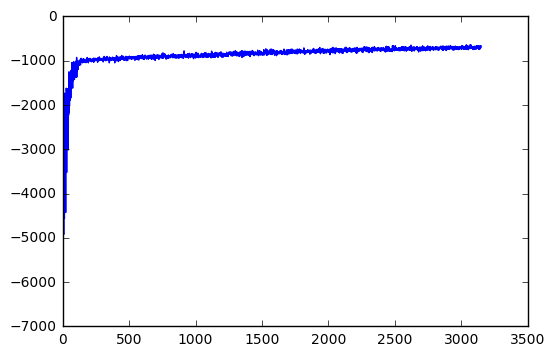

time: 11.1 s


In [68]:
#pd.rolling_mean(dr, 60).plot()
plt.plot(r)
plt.show()


In [70]:
r

[-182937.19,
 -182937.19,
 -58116.5,
 -15716.643,
 -74588.805,
 -60870.434,
 -94771.922,
 -58028.039,
 -31981.943,
 -30729.436,
 -27055.594,
 -46303.738,
 -46303.738,
 -27625.006,
 -9790.7119,
 -68469.773,
 -16773.783,
 -23215.176,
 -10358.177,
 -47120.938,
 -10080.265,
 -13030.263,
 -22157.701,
 -22157.701,
 -18941.359,
 -13098.636,
 -9756.0957,
 -13227.911,
 -19204.219,
 -9579.959,
 -19424.828,
 -24096.383,
 -11794.164,
 -9276.3633,
 -9276.3633,
 -15492.31,
 -13280.396,
 -9519.8477,
 -9189.4082,
 -11323.009,
 -9812.6641,
 -30201.002,
 -10629.354,
 -11715.265,
 -9973.3242,
 -9973.3242,
 -10271.856,
 -11241.281,
 -11192.56,
 -10017.45,
 -12653.22,
 -9235.8359,
 -10840.249,
 -19158.432,
 -9851.3223,
 -9631.9766,
 -9631.9766,
 -9319.8818,
 -10204.132,
 -11105.599,
 -9811.1533,
 -15095.022,
 -16264.184,
 -9364.1768,
 -22028.66,
 -11208.357,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,


time: 19.4 ms


In [135]:
e = tf.constant([[1, 2], [3, 4]])
g = tf.gather_nd(e, [tf.constant([[1, 0], [1, 1]]), tf.constant([[0, 1], [0, 0]])])

with tf.Session() as sess:
    print(sess.run(g))

[[3 4]
 [2 1]]
time: 543 ms


In [131]:
e = tf.constant([[0, 1, 2], [1, 0, -1]])

time: 3.38 ms


In [132]:
e

<tf.Tensor 'Const_16:0' shape=(2, 3) dtype=int32>

time: 3.49 ms


In [176]:
np.median([1, 2, 3])

2.0

time: 42.1 ms


In [205]:
r

[-87063.805,
 -87063.805,
 -42613.492,
 -95466.906,
 -51702.867,
 -119452.19,
 -54361.605,
 -45506.168,
 -45355.227,
 -54363.707,
 -50592.652,
 -64282.707,
 -64282.707,
 -44239.941,
 -42706.688,
 -48918.352,
 -31315.318,
 -12464.795,
 -16229.566,
 -17335.041,
 -34374.93,
 -33092.418,
 -33758.09,
 -33758.09,
 -23054.051,
 -26396.902,
 -23441.33,
 -13553.037,
 -16636.049,
 -22000.59,
 -15910.657,
 -17852.219,
 -22044.727,
 -16584.189,
 -16584.189,
 -13721.631,
 -17386.037,
 -17495.488,
 -17994.559,
 -15598.205,
 -9668.4219,
 -18942.807,
 -17743.613,
 -9740.2227,
 -14156.621,
 -14156.621,
 -10293.151,
 -12772.105,
 -14022.875,
 -12508.376,
 -13253.797,
 -13280.086,
 -9958.9531,
 -6889.3926,
 -9030.5986,
 -14340.563,
 -14340.563,
 -11904.121,
 -10879.037,
 -7775.1309,
 -12467.575,
 -12387.378,
 -11923.172,
 -11323.783,
 -11144.868,
 -10955.39,
 -8239.79,
 -8239.79,
 -8856.7529,
 -8973.5801,
 -10009.217,
 -8228.1475,
 -9959.7656,
 -8921.8408,
 -9621.7822,
 -8656.2256,
 -8147.7202,
 -9009.56

time: 28.5 ms


In [206]:
d = [np.mean(np.sqrt(np.sum((pos[1] - gl[0])**2, axis = 0))) for pos in exp.overall_res]

NameError: name 'gl' is not defined

time: 28.4 ms


In [212]:
n_samples = 20
n_classes = 3
J = np.random.choice(n_classes, n_samples)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(n_values=n_classes, sparse=False)
np.transpose(enc.fit_transform(J.reshape(-1,1)))

array([[ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  1.,  1.,  1.,  0.]])

time: 7.51 ms


In [36]:
for i, k in enumerate(zip([1, 2, 3], [4, 5, 6], [7, 8, 9])):
    print(np.dot(k, [0, 1, 0]))

4
5
6
time: 2.03 ms


In [1]:
1+1

2

In [54]:
np.ones((1, 3))*2

array([[ 2.,  2.,  2.]])

time: 4.02 ms
